In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
# -*- coding: utf-8 -*-


import cv2
from matplotlib import pyplot as plt
import math
import numpy as np



def criterioLowe2NN(descs1, descs2, corresp, ratio=0.7):
  # Matriz de distancias entre keypoints de las dos imágenes
  matriz_dist = np.zeros((len(descs1),len(descs2)), np.float64)
  for i in range(matriz_dist.shape[0]):
    for j in range(matriz_dist.shape[1]):
      matriz_dist[i][j] = np.linalg.norm(descs1[i]-descs2[j])
  
  # Descartar correspondencias según las distancias a los segundos vecinos más cercanos
  corresp_buenas = []
  for corr in corresp:
    i_corr = corr.queryIdx
    j_corr = corr.trainIdx
    mejor_corr = matriz_dist[i_corr][j_corr]
    fila = matriz_dist[i_corr,:]
    fila[j_corr] = 0.
    columna = matriz_dist[:,j_corr]
    columna[i_corr] = 0.
    if mejor_corr < ratio*np.amax(fila) and mejor_corr < ratio*np.amax(columna):
      corresp_buenas.append(corr)
  
  return corresp_buenas


puntos harris: 2252
puntos harris por nivel: [1749  398  105]
porcentajes: [77.6642984 17.6731794  4.6625222]


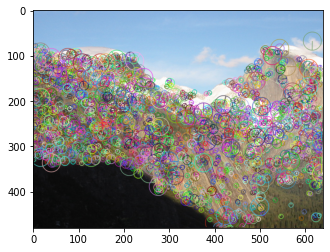

punto harris: (491, 150)
	en el entorno: (45, 45)
punto harris corregido: (491.0, 150.0)
	en el entorno: (45, 45)


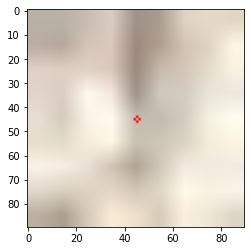

punto harris: (428, 224)
	en el entorno: (45, 45)
punto harris corregido: (430.79874, 222.96947)
	en el entorno: (72, 34)


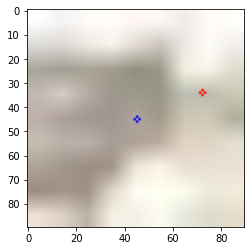

punto harris: (8, 116)
	en el entorno: (45, 45)
punto harris corregido: (8.0, 116.0)
	en el entorno: (45, 45)


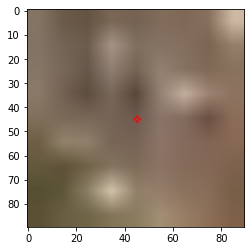

puntos harris: 2027
puntos harris por nivel: [1568  360   99]
porcentajes: [77.35569808 17.7602368   4.88406512]


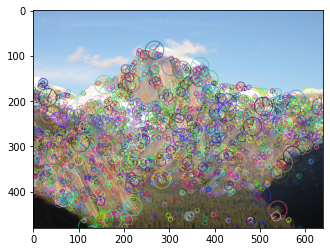

punto harris: (321, 222)
	en el entorno: (45, 45)
punto harris corregido: (318.0412, 222.57263)
	en el entorno: (15, 50)


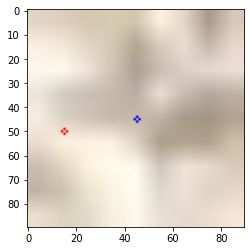

punto harris: (261, 289)
	en el entorno: (45, 45)
punto harris corregido: (261.0, 289.0)
	en el entorno: (45, 45)


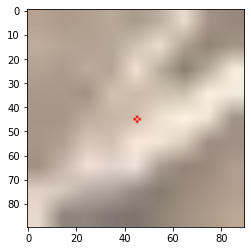

punto harris: (376, 305)
	en el entorno: (45, 45)
punto harris corregido: (373.23462, 306.56778)
	en el entorno: (17, 60)


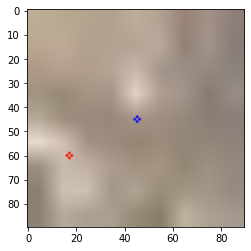

In [16]:
################################################################################
################################# EJERCICIO 1 ##################################
################################################################################

def deteccionPuntosHarris(img, block_size, ksize, dist_max, umbral):
  # Creación la pirámida gaussiana con imágenes a escala de gris
  pir_gauss = []
  pir_gauss.append(cv2.cvtColor(img,cv2.COLOR_BGR2GRAY).astype(np.float32)/255.)
  pir_gauss.append(cv2.pyrDown(pir_gauss[0]))
  pir_gauss.append(cv2.pyrDown(pir_gauss[1]))

  # Vector con los puntos Harris
  puntos_harris = []

  # Contador para los puntos harris de cada nivel
  contador_puntos_harris = np.zeros(3, dtype=np.uint32)


  for nivel in range(3):
    # Obtenemos los valores propios y los vectores propios de cada píxel
    eigenvals = cv2.cornerEigenValsAndVecs(pir_gauss[nivel], block_size, ksize)
    # Obtenemos el criterio Harris de cada píxel
    # (sumamos cantidad despreciable en el denominador para evitar dividir por cero)
    crit_harris = np.divide(eigenvals[:,:,0]*eigenvals[:,:,1],
                                eigenvals[:,:,0]+eigenvals[:,:,1]+0.000001)

    # Imágenes usadas para el cálculo del gradiente (orientación)
    # 1. Alisamiento con sigma=4.5
    # 2. Derivadas parciales en x e y con el operador sobel 
    sigma = 4.5
    tam = 2*math.ceil(3*sigma)+1
    img_alisada = cv2.GaussianBlur(pir_gauss[nivel], (tam,tam), sigma)
    img_sobel_x = cv2.Sobel(img_alisada, cv2.CV_64F, 1, 0)
    img_sobel_y = cv2.Sobel(img_alisada, cv2.CV_64F, 0, 1)

    
    # Creo matriz auxiliar que guarda los puntos que aún quedan por reexplorar
    # Primero, marco como explorados aquellos puntos por debajo del umbral
    matriz_aux = crit_harris < umbral

    # Mitad del lado de la ventana
    mitad_ventana = (dist_max-1)//2
    
    for i in range(crit_harris.shape[0]):
      for j in range(crit_harris.shape[1]):
        if matriz_aux[i][j] == False:
          # Cálculo de la ventana en la que se comprueba si el píxel es máximo
          i_min = max(0,i-mitad_ventana)
          j_min = max(0,j-mitad_ventana)
          i_max = min(crit_harris.shape[0],i+mitad_ventana+1)
          j_max = min(crit_harris.shape[1],j+mitad_ventana+1)
          ventana = crit_harris[i_min:i_max,j_min:j_max]
          # Comprobación de si el píxel es máximo en la ventana
          if crit_harris[i][j] == np.amax(ventana):
            # Marco ventana como explorada en la matriz auxiliar
            matriz_aux[i_min:i_max,j_min:j_max] = True
            # Cálculo de la orientación
            gradiente = [img_sobel_x[i][j], img_sobel_y[i][j]]
            gradiente_norm = gradiente / np.linalg.norm(gradiente)
            orientacion = np.arccos(gradiente_norm[0])*(180.0/np.pi)
            if gradiente[1] < 0.0:
              orientacion = 360.0-orientacion
            # Se añade el píxel a los puntos Harris en una estructura KeyPoint
            puntos_harris.append(cv2.KeyPoint(2**nivel*j, 2**nivel*i, 
                                              2**(nivel+1)*block_size, orientacion))
            # Incrementamos el contador de puntos harris
            contador_puntos_harris[nivel] += 1
          else:
            # Marco punto como explorado en la matriz auxiliar
            matriz_aux[i][j] = True
  
  
  print("puntos harris:",np.sum(contador_puntos_harris))
  print("puntos harris por nivel:",contador_puntos_harris)
  print("porcentajes:",contador_puntos_harris*100/np.sum(contador_puntos_harris))
  

  # Dibujar la imagen con los puntos harris
  img_keypoints = cv2.drawKeypoints(img, puntos_harris, None, 
                                    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
  plt.imshow(cv2.cvtColor(img_keypoints,cv2.COLOR_BGR2RGB))
  plt.show()


  # Coordenadas de cada punto Harris
  corners = [kp.pt for kp in puntos_harris]
  corners = np.array(corners, dtype=np.float32)
  # Criterio de parada de 50 iteraciones y epsilon=0.01
  crit_parada = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_MAX_ITER, 50, 0.01)
  # Aplicar algoritmo Corner Supixel
  corners_corregidos = corners.copy()
  cv2.cornerSubPix(pir_gauss[0], corners_corregidos, (3,3), (-1,-1), crit_parada)


  # Mitad del lado del entorno del píxel
  mitad_entorno = 4
  # Zoom aplicado al entorno del píxel
  zoom = 10

  # Selección aleatoria de 3 puntos Harris (diferentes y no pegados al borde)
  indices_aleatorios = None
  indices_invalidos = True
  while indices_invalidos:
    indices_aleatorios = np.random.randint(corners.shape[0], size=3)
    indices_invalidos = False
    for k in range(3):
      if ( corners[indices_aleatorios[k]][0] < mitad_entorno
           or corners[indices_aleatorios[k]][1] >= img.shape[0]-mitad_entorno
           or corners[indices_aleatorios[k]][0] < mitad_entorno
           or corners[indices_aleatorios[k]][1] >= img.shape[0]-mitad_entorno
           or indices_aleatorios[k] == indices_aleatorios[(k+1)%3] ):
        indices_invalidos = True


  # Comparación de puntos harris aleatorios con sus refinamientos subpixel
  for k in indices_aleatorios:
    # Selección del entorno del punto harris
    j = int(corners[k][0])
    i = int(corners[k][1])
    entorno = img[i-mitad_entorno:i+mitad_entorno+1,j-mitad_entorno:j+mitad_entorno+1]
    tam_ventana = zoom*(2*mitad_entorno+1)
    entorno_zoom = cv2.resize(entorno, (tam_ventana,tam_ventana), 
                              interpolation=cv2.INTER_LINEAR)

    # Añadir punto harris al entorno
    coords = (int(tam_ventana/2),int(tam_ventana/2))
    print("punto harris: ("+str(j)+", "+str(i)+")")
    print("\ten el entorno:",coords)
    entorno_zoom = cv2.circle(entorno_zoom, coords, 1, (255,0,0), 1)

    # Añadir refinamiento subpixel al entorno
    coords_corregidas = tuple(np.array(coords + zoom*corners_corregidos[k] - zoom*corners[k]).astype(np.uint8))
    print("punto harris corregido: ("+str(corners_corregidos[k][0])+", "+str(corners_corregidos[k][1])+")")
    print("\ten el entorno:",coords_corregidas)
    entorno_zoom = cv2.circle(entorno_zoom, coords_corregidas, 1, (0,0,255), 1)

    # Mostrar entorno
    plt.imshow(cv2.cvtColor(entorno_zoom,cv2.COLOR_BGR2RGB))
    plt.show()
  

  return img_keypoints




block_size = 5
ksize = 5
dist_max = 5
umbral = 0.015

yosemite1 = cv2.imread('./imagenes/Yosemite1.jpg')
yosemite1_kpts = deteccionPuntosHarris(yosemite1, block_size, ksize, dist_max, umbral)

yosemite2 = cv2.imread('./imagenes/Yosemite2.jpg')
yosemite2_kpts = deteccionPuntosHarris(yosemite2, block_size, ksize, dist_max, umbral)




Correspondencias encontradas (antes de Lowe 2-NN): 495
Correspondencias encontradas (después de Lowe 2-NN): 342


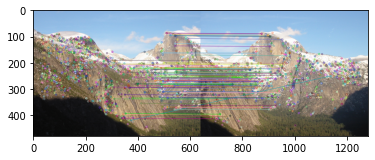

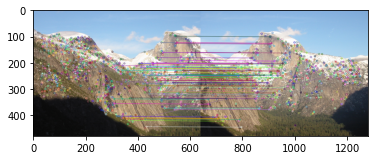

In [17]:
################################################################################
################################# EJERCICIO 2 ##################################
################################################################################

def correspondenciasAKAZE(img1, img2):
  # Obtener imágenes a escala de gris
  gray1 = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY).astype(np.float32)/255.
  gray2 = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY).astype(np.float32)/255.

  # Detección de keypoints y extracción de descriptores AKAZE
  akaze = cv2.AKAZE_create()
  kpts1, descs1 = akaze.detectAndCompute(gray1, None)
  kpts2, descs2 = akaze.detectAndCompute(gray2, None)

  # Establecer correspondencias entre imágenes
  matcher = cv2.BFMatcher_create(normType=cv2.NORM_L2, crossCheck=True)
  corresp = matcher.match(descs1, descs2)

  print("Correspondencias encontradas (antes de Lowe 2-NN):", len(corresp))

  corresp = criterioLowe2NN(descs1, descs2, corresp)

  print("Correspondencias encontradas (después de Lowe 2-NN):", len(corresp))

  return kpts1, kpts2, corresp




yosemite1 = cv2.imread('./imagenes/Yosemite1.jpg')
yosemite2 = cv2.imread('./imagenes/Yosemite2.jpg')

kpts1, kpts2, corresp = correspondenciasAKAZE(yosemite1, yosemite2)

for i in range(1,3):
  # Selección aleatoria de 100 correspondencias (diferentes)
  indices_aleatorios = np.random.randint(len(corresp), size=100)
  for k in range(len(indices_aleatorios)):
    while indices_aleatorios[k] == indices_aleatorios[(k-1)%100]:
      indices_aleatorios[k] = np.random.randint(len(corresp))
  corresp100 = [corresp[k] for k in indices_aleatorios]

  img_corresp = cv2.drawMatches(yosemite1, kpts1, yosemite2, kpts2, corresp100, None)
  plt.imshow(cv2.cvtColor(img_corresp, cv2.COLOR_BGR2RGB))
  plt.show()




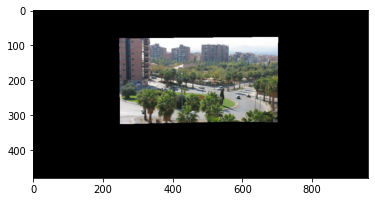

In [18]:
################################################################################
################################# EJERCICIO 3 ##################################
################################################################################

def mosaico3Imagenes(img1, img2, img3):
  # Obtener imágenes a escala de gris
  img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
  img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
  img3_gray = cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY)

  # Detección de keypoints y extracción de descriptores AKAZE
  akaze = cv2.AKAZE_create()
  kpts1, descs1 = akaze.detectAndCompute(img1_gray, None)
  kpts2, descs2 = akaze.detectAndCompute(img2_gray, None)
  kpts3, descs3 = akaze.detectAndCompute(img3_gray, None)
  
  # Establecer correspondencias entre imágenes
  matcher = cv2.BFMatcher_create(crossCheck=True)
  corresp12 = matcher.match(descs1, descs2)
  corresp32 = matcher.match(descs3, descs2)

  # Aplicar criterio Lowe 2-NN
  corresp12 = criterioLowe2NN(descs1,descs2,corresp12)
  corresp32 = criterioLowe2NN(descs3,descs2,corresp32)
  

  # Estimación de homografías
  src_pts = np.float32([kpts1[corr.queryIdx].pt for corr in corresp12]).reshape(-1,1,2)
  dst_pts = np.float32([kpts2[corr.trainIdx].pt for corr in corresp12]).reshape(-1,1,2)
  h12, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
  
  src_pts = np.float32([kpts3[corr.queryIdx].pt for corr in corresp32]).reshape(-1,1,2)
  dst_pts = np.float32([kpts2[corr.trainIdx].pt for corr in corresp32]).reshape(-1,1,2)
  h32, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)


  # Definir la imagen mosaico
  imgs = [img1,img2,img3]
  altura = 2*np.amax([img.shape[0] for img in imgs])
  anchura = np.sum([img.shape[1] for img in imgs])
  mosaico = np.zeros((altura,anchura,3), dtype=np.uint8)

  # Definir la homografía que lleva la imagen central al mosaico
  inc_alt = altura//6
  inc_anch = (anchura*(len(imgs)-1))//(2*len(imgs))
  h0 = np.array((1,0,inc_anch,0,1,inc_alt,0,0,1),dtype=np.float64).reshape((3,3))


  # Colocar la imagen 1 en el mosaico
  h1 = h0 @ h12
  cv2.warpPerspective(img1, h1, (anchura,altura), mosaico, borderMode=cv2.BORDER_TRANSPARENT)
    
  # Colocar la imagen 3 en el mosaico
  h3 = h0 @ h32
  cv2.warpPerspective(img3, h3, (anchura,altura), mosaico, borderMode=cv2.BORDER_TRANSPARENT)

  # Colocar la imagen 2 en el mosaico
  cv2.warpPerspective(img2, h0, (anchura,altura), mosaico, borderMode=cv2.BORDER_TRANSPARENT)
  
  
  return mosaico

  

mosaico2 = cv2.imread('./imagenes/mosaico002.jpg')
mosaico3 = cv2.imread('./imagenes/mosaico003.jpg')
mosaico4 = cv2.imread('./imagenes/mosaico004.jpg')
mosaico = mosaico3Imagenes(mosaico2, mosaico3, mosaico4)
plt.imshow(cv2.cvtColor(mosaico, cv2.COLOR_BGR2RGB))
plt.show()

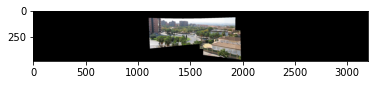

In [19]:
################################################################################
################################# EJERCICIO 4 ##################################
################################################################################

def mosaicoNImagenes(imgs):
  # Inviertir el orden de las imágenes para que estén de izquierda a derecha
  imgs = list(reversed(imgs))

  # Obtener imágenes a escala de gris
  imgs_gray = []
  for img in imgs:
    imgs_gray.append(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))

  # Extraer keypoints y descriptores AKAZE
  kpts = []
  descs = []
  akaze = cv2.AKAZE_create()
  for k in range(len(imgs_gray)):
    keypoints, descriptors = akaze.detectAndCompute(imgs_gray[k], None)
    kpts.append(keypoints)
    descs.append(descriptors)
  
  # Establecer correspondencias entre imágenes
  centro = len(imgs)//2
  matcher = cv2.BFMatcher_create(normType=cv2.NORM_L2, crossCheck=True)
  corresp_izq = []
  for k in range(centro):
    corr = matcher.match(descs[k], descs[k+1])
    corr = criterioLowe2NN(descs[k], descs[k+1], corr)
    corresp_izq.append(corr)
  corresp_der = []
  for k in range(len(imgs)-1,centro,-1):
    corr = matcher.match(descs[k], descs[k-1])
    corr = criterioLowe2NN(descs[k], descs[k-1], corr)
    corresp_der.append(corr)
  

  # Estimación de homografías
  hom_izq = []
  for k in range(len(corresp_izq)):
    src_pts = np.float32([kpts[k][corr.queryIdx].pt for corr in corresp_izq[k]]).reshape(-1,1,2)
    dst_pts = np.float32([kpts[k+1][corr.trainIdx].pt for corr in corresp_izq[k]]).reshape(-1,1,2)
    h, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    hom_izq.append(h)
  hom_der = []
  for k in range(len(corresp_der)):
    src_pts = np.float32([kpts[len(imgs)-k-1][corr.queryIdx].pt for corr in corresp_der[k]]).reshape(-1,1,2)
    dst_pts = np.float32([kpts[len(imgs)-k-2][corr.trainIdx].pt for corr in corresp_der[k]]).reshape(-1,1,2)
    h, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    hom_der.append(h)


  # Definir la imagen mosaico
  altura = 2*np.amax([img.shape[0] for img in imgs])
  anchura = np.sum([img.shape[1] for img in imgs])
  mosaico = np.zeros((altura,anchura,3), dtype=np.uint8)

  # Definir la homografía que lleva la imagen central al mosaico
  inc_alt = altura//6
  inc_anch = (anchura*(len(imgs)-1))//(2*len(imgs))
  h0 = np.array((1,0,inc_anch,0,1,inc_alt,0,0,1),dtype=np.float64).reshape((3,3))


  # Definir el resto de homografías por composición
  hom = []
  hom.append(h0)
  for k in range(len(hom_izq)-1,-1,-1):
    hom.insert(0, hom[0] @ hom_izq[k])
  for k in range(len(hom_der)-1,-1,-1):
    hom.append(hom[-1] @ hom_der[k])

  # Colocar las imágenes en el mosaico
  for k in range(centro):
    cv2.warpPerspective(imgs[k], hom[k], (anchura,altura), mosaico, borderMode=cv2.BORDER_TRANSPARENT)
  for k in range(len(imgs)-1,centro,-1):
    cv2.warpPerspective(imgs[k], hom[k], (anchura,altura), mosaico, borderMode=cv2.BORDER_TRANSPARENT)
  cv2.warpPerspective(imgs[centro], hom[centro], (anchura,altura), mosaico, borderMode=cv2.BORDER_TRANSPARENT)
  

  return mosaico



mosaico2 = cv2.imread('./imagenes/mosaico002.jpg')
mosaico3 = cv2.imread('./imagenes/mosaico003.jpg')
mosaico4 = cv2.imread('./imagenes/mosaico004.jpg')
mosaico5 = cv2.imread('./imagenes/mosaico005.jpg')
mosaico6 = cv2.imread('./imagenes/mosaico006.jpg')
mosaico7 = cv2.imread('./imagenes/mosaico007.jpg')
mosaico8 = cv2.imread('./imagenes/mosaico008.jpg')
mosaico9 = cv2.imread('./imagenes/mosaico009.jpg')
mosaico10 = cv2.imread('./imagenes/mosaico010.jpg')
mosaico11 = cv2.imread('./imagenes/mosaico011.jpg')
imgs = [mosaico11,mosaico10,mosaico9,mosaico8,mosaico7,mosaico6,mosaico5,\
        mosaico4,mosaico3,mosaico2]
mosaico = mosaicoNImagenes(imgs)
plt.imshow(cv2.cvtColor(mosaico, cv2.COLOR_BGR2RGB))
plt.show()
